In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# Load Data from Dump

In [2]:
DUMP_PATH = "./dumps/"
REPORT_FILE_PATH = f"{DUMP_PATH}report.json"

In [3]:
f = open(REPORT_FILE_PATH)
  
data = json.load(f)

f.close()

In [4]:
ciphers = ["aes", "des", "rc4"]

for cipher in ciphers:
    resultDirPath = DUMP_PATH + cipher + "/"
    
    resData = []
    
    for root, dirs, files in os.walk(resultDirPath, topdown=True):
        for file in files:
            if ".json" in file:
                print(f"Working on {cipher} {file}")
                
                resFile = open(f"{resultDirPath}{file}")
                
                rd = json.load(resFile)
                
                resData.append(rd)

                resFile.close()
          
    # sort key by plain text id in ascending order
    resData.sort(key=lambda x: x["plainTextId"])
        
    # verify data is sorted by plain text id in ascending order
    print([i["plainTextId"] for i in resData])
    
    data[cipher] = resData

Working on aes 10mb_binary.bin.json
Working on aes 10mb_text.txt.json
Working on aes 1mb_binary.bin.json
Working on aes 1mb_text.txt.json
Working on aes 50mb_binary.bin.json
Working on aes 50mb_text.txt.json
[0, 1, 2, 3, 4, 5]
Working on des 10mb_binary.bin.json
Working on des 10mb_text.txt.json
Working on des 1mb_binary.bin.json
Working on des 1mb_text.txt.json
Working on des 50mb_binary.bin.json
Working on des 50mb_text.txt.json
[0, 1, 2, 3, 4, 5]
Working on rc4 10mb_binary.bin.json
Working on rc4 10mb_text.txt.json
Working on rc4 1mb_binary.bin.json
Working on rc4 1mb_text.txt.json
Working on rc4 50mb_binary.bin.json
Working on rc4 50mb_text.txt.json
[0, 1, 2, 3, 4, 5]


In [5]:
ASCII_CHAR_COUNT = 256

In [6]:
class TextData:
    def __init__(self, asciiCodes):
        self.length = len(asciiCodes)
        self.fTable = self.getAsciiCodesFTable(asciiCodes)
        self.str = self.cvtAsciiCodesToStr(asciiCodes)
        self.bins = self.cvtStrToBins(asciiCodes)
        
    def getAsciiCodesFTable(self, asciiCodes):
        fTable = [0] * ASCII_CHAR_COUNT
        
        for asciiCode in asciiCodes:
            fTable[asciiCode] += 1
            
        return fTable
    
    def cvtAsciiCodesToStr(self, asciiCodes):
        # ref: https://www.reddit.com/r/learnpython/comments/r1n6oh/how_do_i_print_extended_ascii_codes/
        return bytes(asciiCodes).decode('cp437')
    
    def cvtStrToBins(self, asciiCodes):
        return "".join(["{0:08b}".format(i) for i in asciiCodes])

In [7]:
class Result:
    def __init__(
        self,
        plainTextId,
        cipherTextAsciiCodes,
        encRtMean,
        encRtPopStdDev,
        decRtMean,
        decRtPopStdDev
    ):
        self.plainTextId = plainTextId
        self.cipherText = TextData(cipherTextAsciiCodes)
        self.encRtMean = encRtMean
        self.encRtPopStdDev = encRtPopStdDev
        self.decRtMean = decRtMean
        self.decRtPopStdDev = decRtPopStdDev


In [8]:
PT_DATA = [TextData(asciiCodes) for asciiCodes in data["plainTexts"]]

In [37]:
pd.DataFrame(data={
    "file name": [
        "1mb_binary.bin",
        "1mb_text.txt",
        "10mb_binary.bin",
        "10mb_text.txt",
        "50mb_binary.bin",
        "50mb_text.txt"
    ],
    "plain text length": [i.length for i in PT_DATA]
})

,file name,plain text length
0,1mb_binary.bin,1048576
1,1mb_text.txt,1200012
2,10mb_binary.bin,10485760
3,10mb_text.txt,10485760
4,50mb_binary.bin,51380224
5,50mb_text.txt,51380224


In [10]:
def toResults(data):
    results = []
    for d in data:
        results.append(Result(
            plainTextId = d["plainTextId"],
            cipherTextAsciiCodes = d["cipherText"],
            encRtMean = d["encRtMean"],
            encRtPopStdDev = d["encRtPopStdDev"],
            decRtMean = d["decRtMean"],
            decRtPopStdDev = d["decRtPopStdDev"]
        ))
    return results

In [11]:
RES_DATA = {
    "aes": toResults(data["aes"]),
    "des": toResults(data["des"]),
    "rc4": toResults(data["rc4"])
}

In [12]:
data["nIter"]

10

# Plot ASCII Character Frequency

In [13]:
def plotAsciiCodeFreqMap(data, cipherName):
    if len(data) == 0:
        return
    
    colCount = 2
    rowCount = len(data)
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 30))
    
    fig.suptitle(f"ASCII Character Frequency {cipherName}", fontsize=16)

    x = np.array(range(0, ASCII_CHAR_COUNT))
    
    for i in range(0, rowCount):
        ax[i, 0].plot(x, np.array(PT_DATA[i].fTable))
        ax[i, 0].set_title(f"Plain Text ({PT_DATA[i].length})")
        ax[i, 0].set_xlabel('ASCII Code')
        ax[i, 0].set_ylabel('Frequency')
        
        ax[i, 1].plot(x, np.array(data[i].cipherText.fTable))
        ax[i, 1].set_title(f"Cipher Text ({data[i].cipherText.length})")
        ax[i, 1].set_xlabel('ASCII Code')
        ax[i, 1].set_ylabel('Frequency')

    fig.tight_layout()
    
    fig.subplots_adjust(top=0.95)
    
    plt.show()

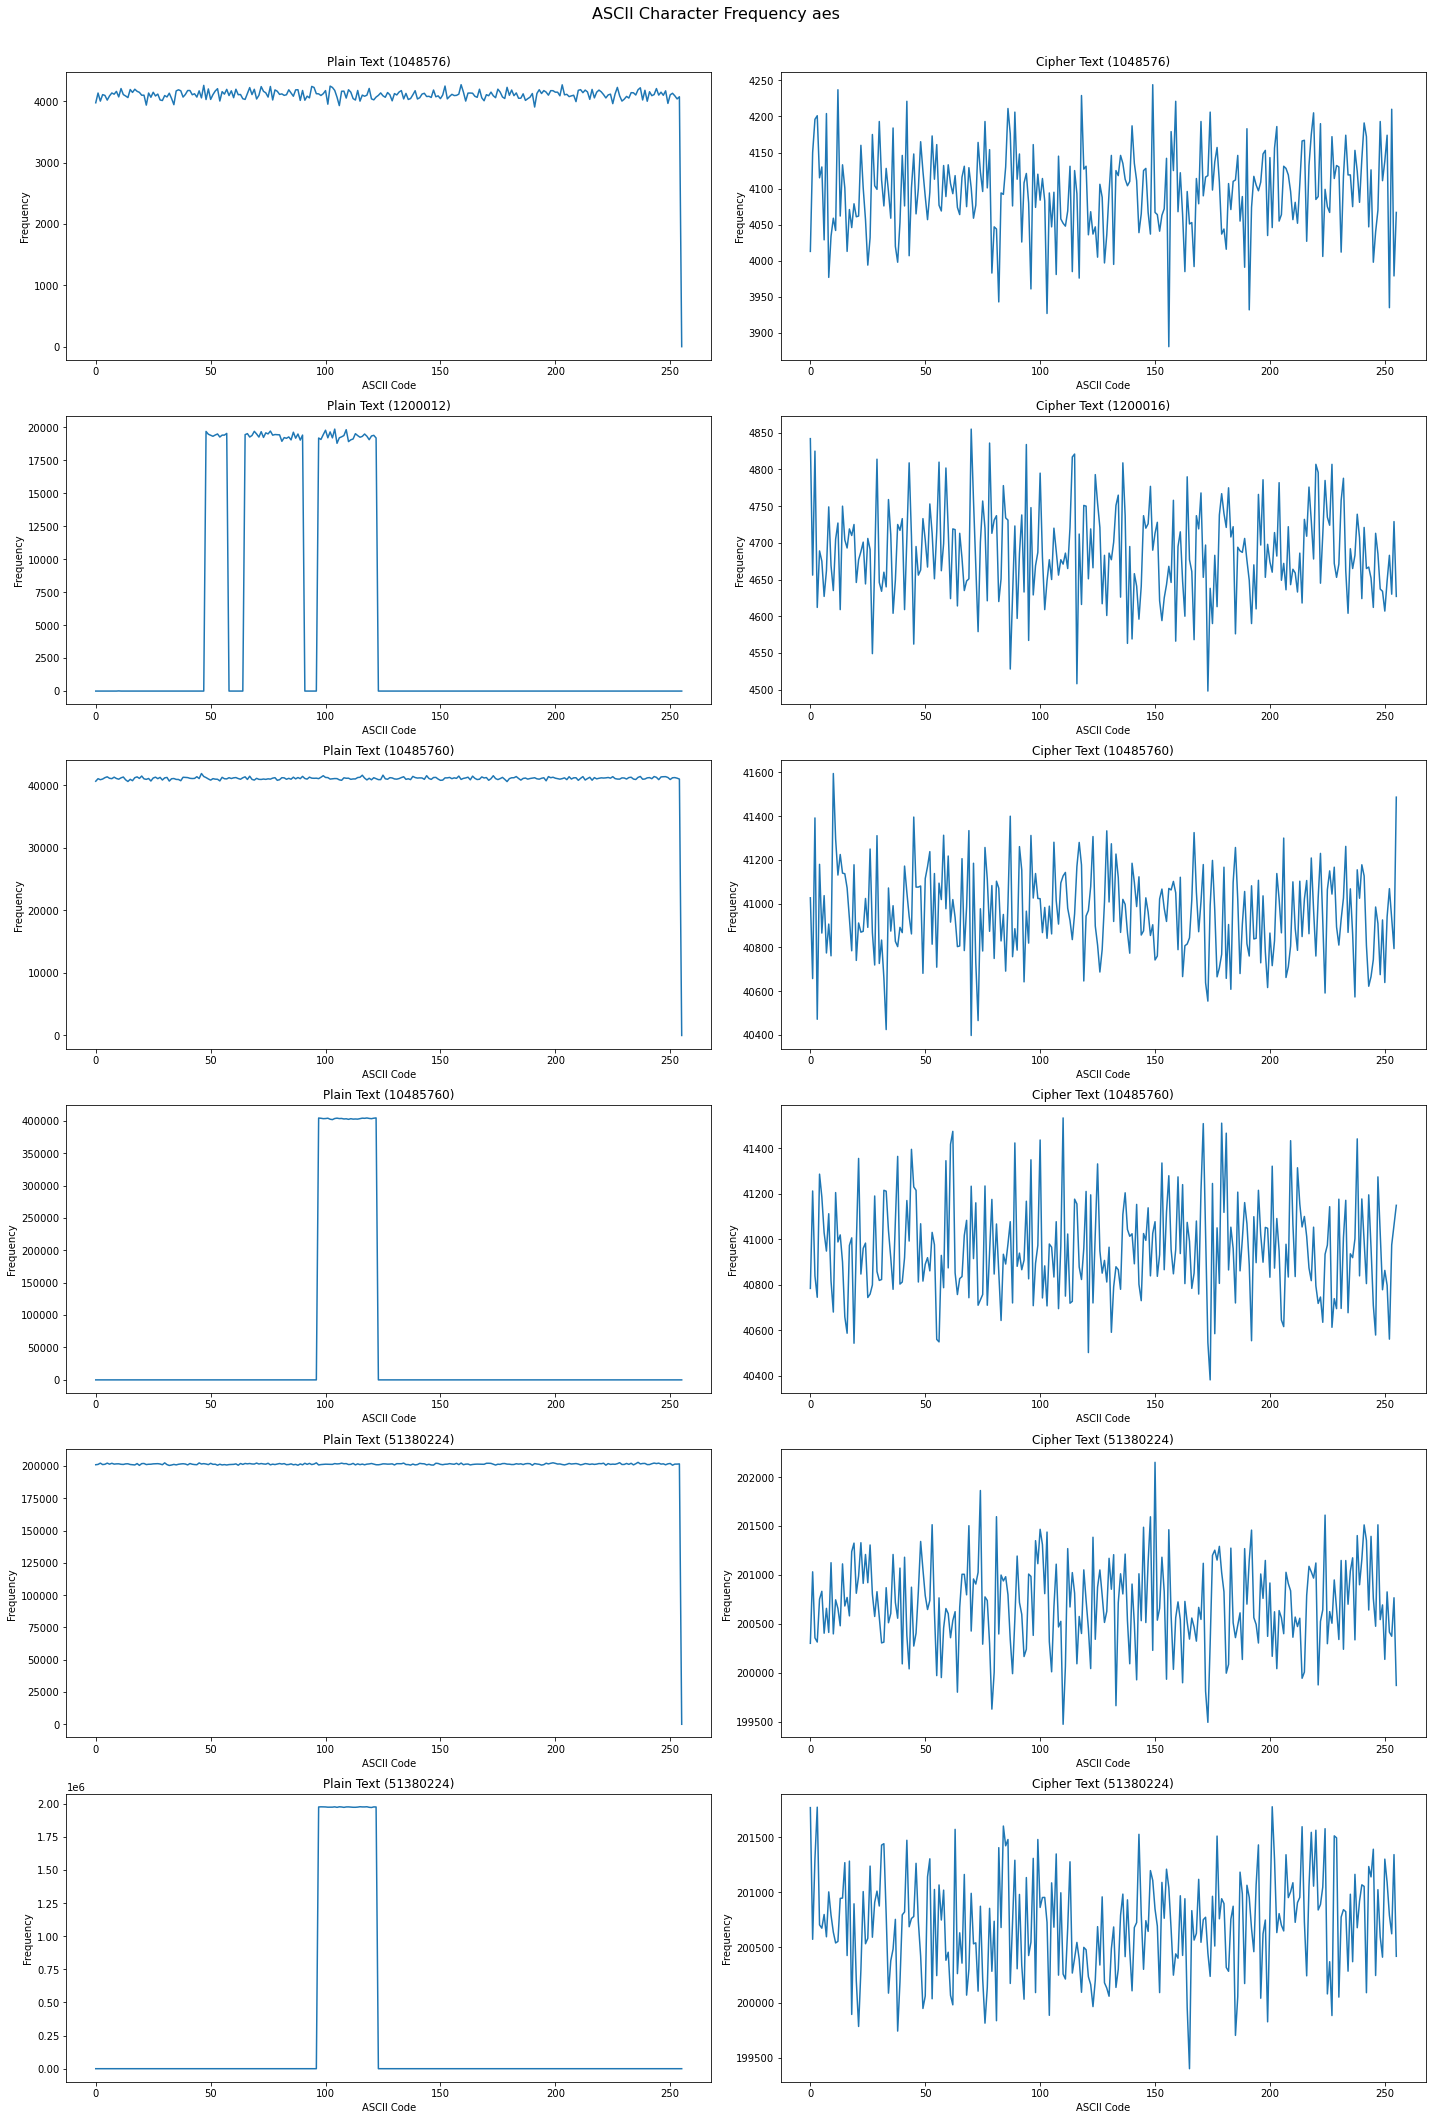

In [14]:
plotAsciiCodeFreqMap(RES_DATA["aes"], "aes")

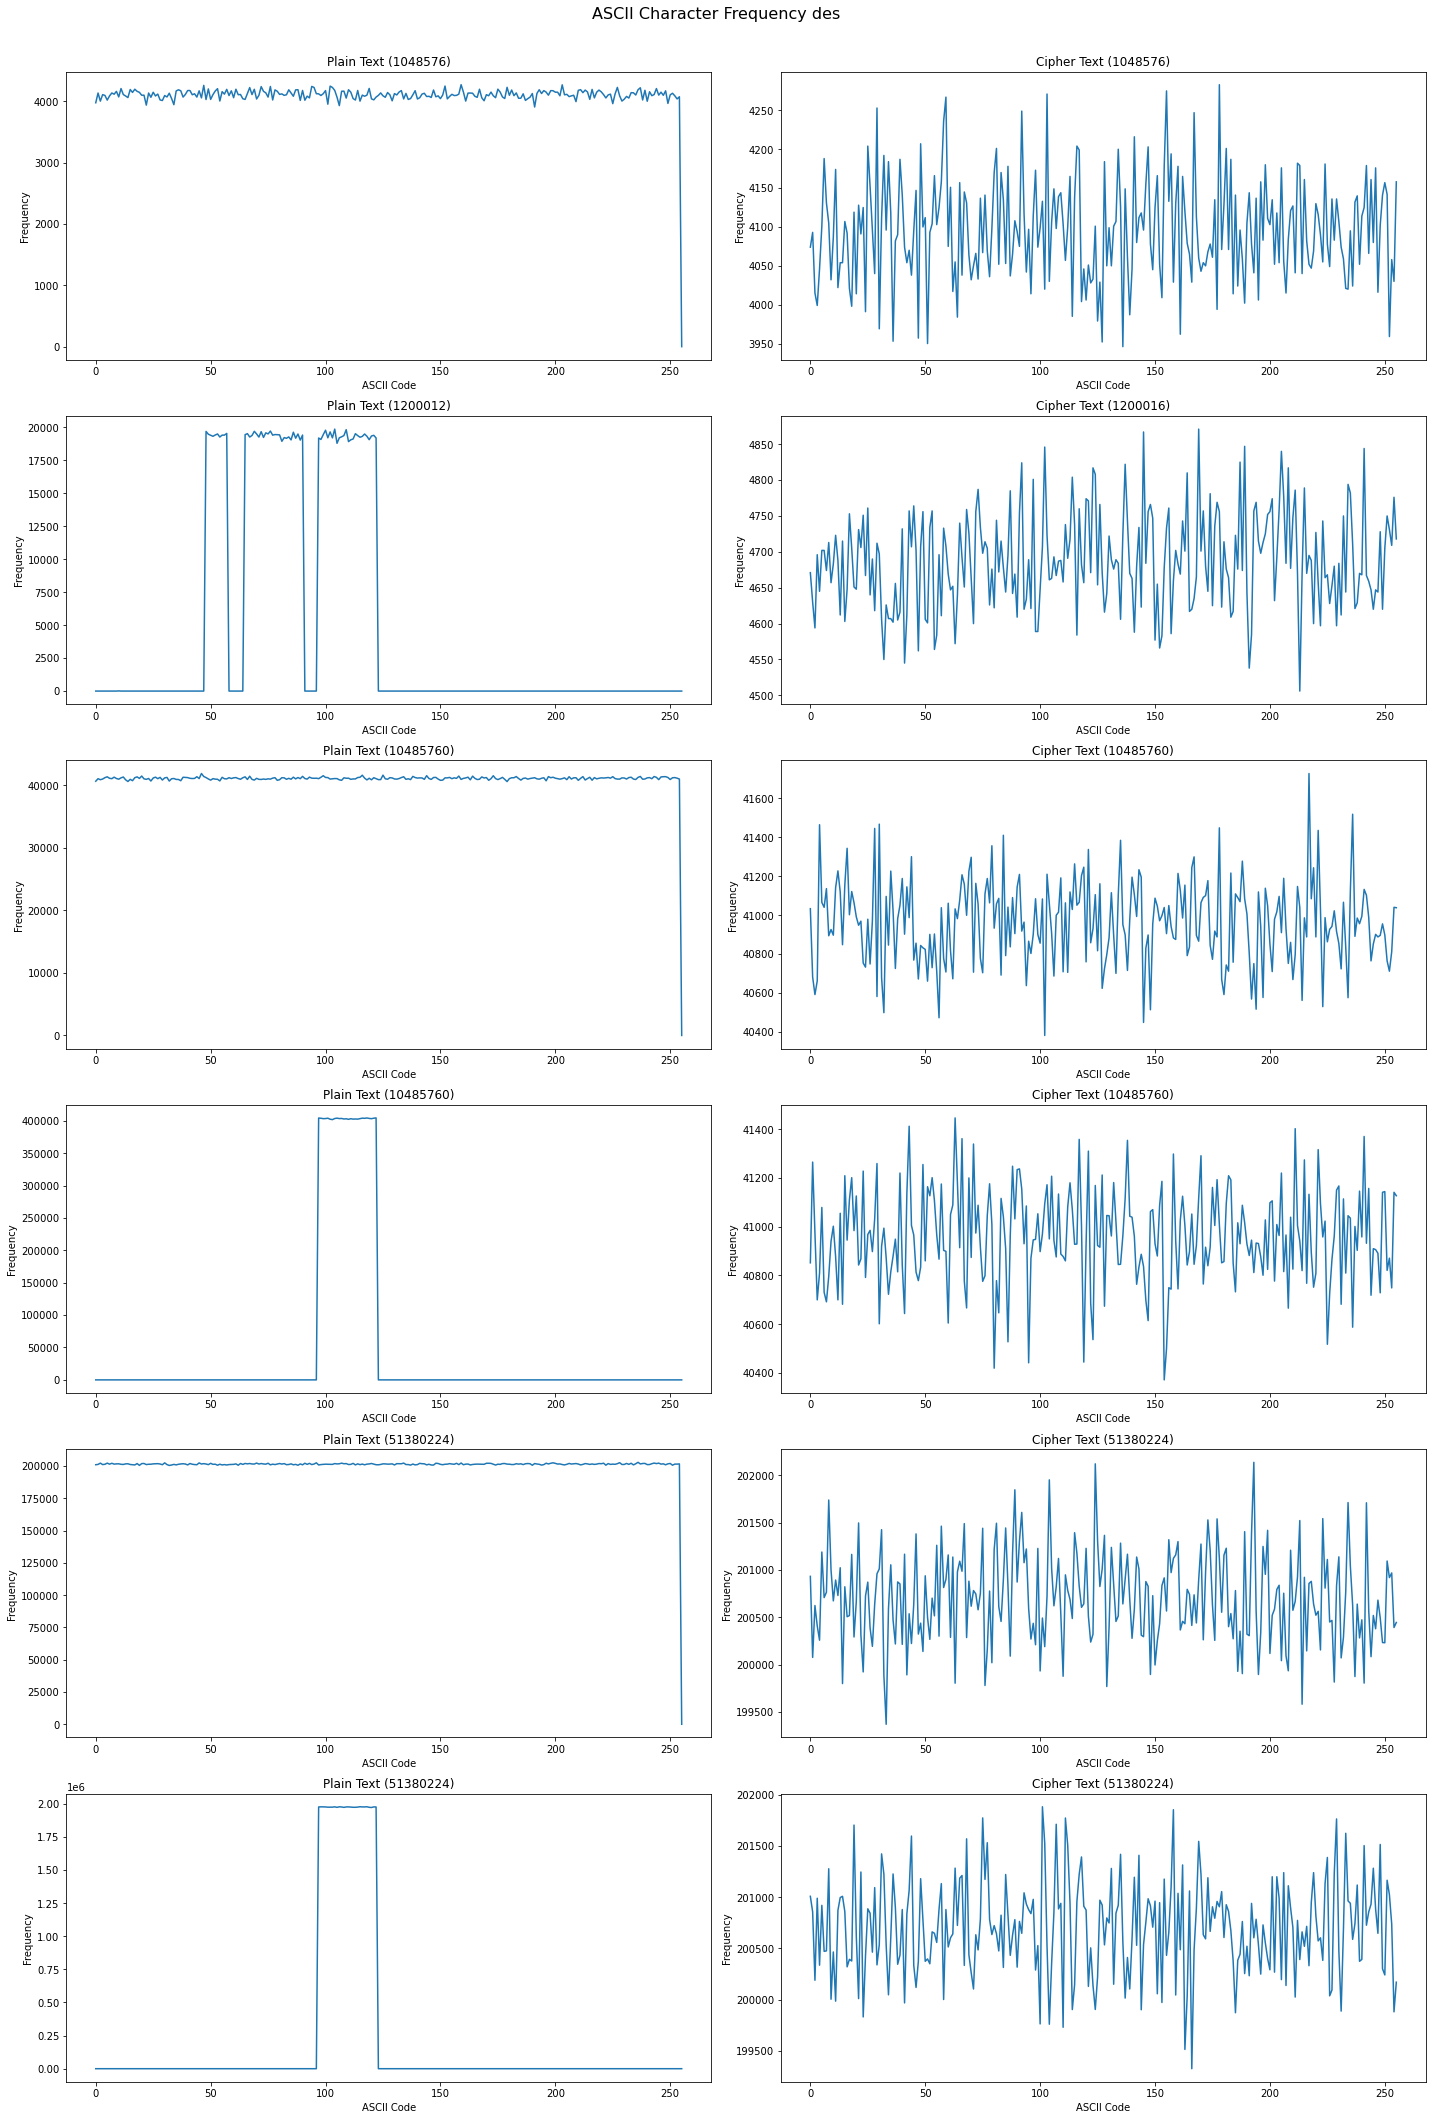

In [15]:
plotAsciiCodeFreqMap(RES_DATA["des"], "des")

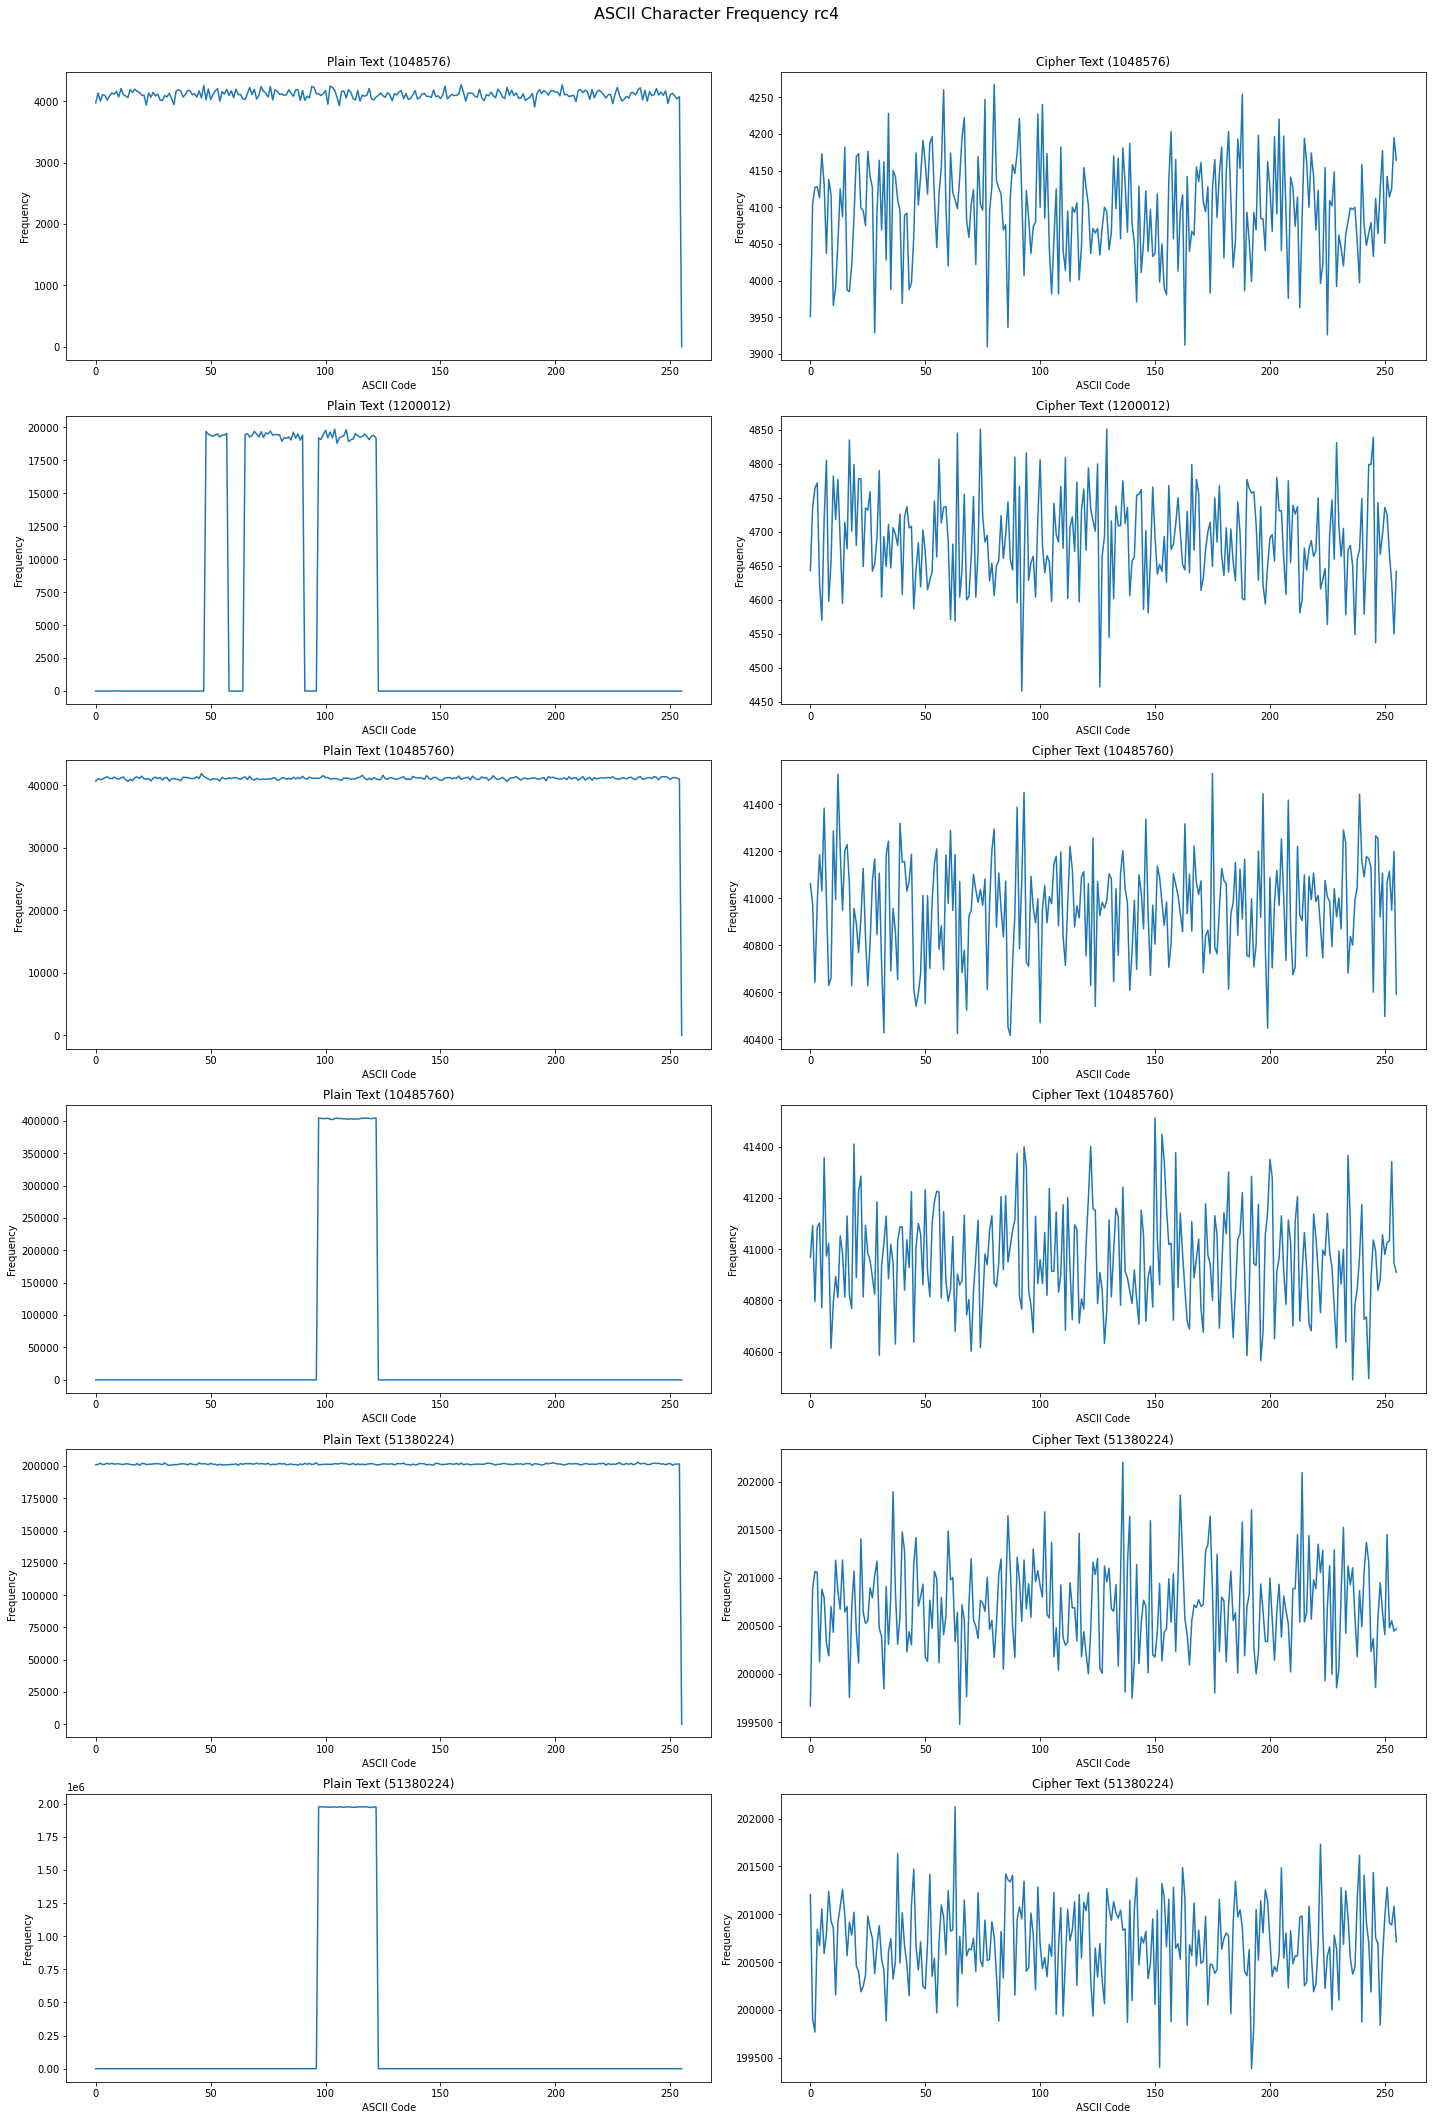

In [16]:
plotAsciiCodeFreqMap(RES_DATA["rc4"], "rc4")

# Print Count of Zeros and Ones

In [17]:
def countZerosAndOnes(str):
    oneCount = 0
    for c in str:
        if c == "1":
            oneCount += 1
    return abs(len(str) - oneCount), oneCount

def getZeroesAndOnesInPlainTextAndCipherTextTable(data):
    ptZeroCounts = []
    ptOneCounts = []
    
    ctZeroCounts = []
    ctOneCounts = []
    
    for i in range(0, len(data)):
        ptZeroCount, ptOneCount = countZerosAndOnes(PT_DATA[i].bins)
        ptZeroCounts.append(ptZeroCount)
        ptOneCounts.append(ptOneCount)
        
        ctZeroCount, ctOneCount = countZerosAndOnes(data[i].cipherText.bins)
        ctZeroCounts.append(ctZeroCount)
        ctOneCounts.append(ctOneCount)
    
    return pd.DataFrame(data={
        "plain text length": [i.length for i in PT_DATA],
        "cipher text length": [d.cipherText.length for d in data],
        
        "plain text total bits": [len(i.bins) for i in PT_DATA],
        "cipher text total bits": [len(d.cipherText.bins) for d in data],
        
        "plain text 0s": ptZeroCounts,
        "plain text 1s": ptOneCounts,
        
        "cipher text 0s": ctZeroCounts,
        "cipher text 1s": ctOneCounts,
    })

In [18]:
getZeroesAndOnesInPlainTextAndCipherTextTable(RES_DATA["aes"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,1048576,1048576,8388608,8388608,4209351,4179257,4193729,4194879
1,1200012,1200016,9600096,9600128,5094728,4505368,4802078,4798050
2,10485760,10485760,83886080,83886080,42102795,41783285,41944833,41941247
3,10485760,10485760,83886080,83886080,38717003,45169077,41943956,41942124
4,51380224,51380224,411041792,411041792,206309079,204732713,205534375,205507417
5,51380224,51380224,411041792,411041792,189711491,221330301,205509393,205532399


In [19]:
getZeroesAndOnesInPlainTextAndCipherTextTable(RES_DATA["des"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,1048576,1048576,8388608,8388608,4209351,4179257,4194260,4194348
1,1200012,1200016,9600096,9600128,5094728,4505368,4798620,4801508
2,10485760,10485760,83886080,83886080,42102795,41783285,41942993,41943087
3,10485760,10485760,83886080,83886080,38717003,45169077,41937716,41948364
4,51380224,51380224,411041792,411041792,206309079,204732713,205518732,205523060
5,51380224,51380224,411041792,411041792,189711491,221330301,205523325,205518467


In [20]:
getZeroesAndOnesInPlainTextAndCipherTextTable(RES_DATA["rc4"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,1048576,1048576,8388608,8388608,4209351,4179257,4194174,4194434
1,1200012,1200012,9600096,9600096,5094728,4505368,4802298,4797798
2,10485760,10485760,83886080,83886080,42102795,41783285,41938288,41947792
3,10485760,10485760,83886080,83886080,38717003,45169077,41946422,41939658
4,51380224,51380224,411041792,411041792,206309079,204732713,205514970,205526822
5,51380224,51380224,411041792,411041792,189711491,221330301,205503736,205538056


# Plot Running Times Mean

In [21]:
def getEncRtMeanTable():
    plainTextLengths = [i.length for i in PT_DATA]
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "aes": [i.encRtMean for i in RES_DATA["aes"]],
        "des": [i.encRtMean for i in RES_DATA["des"]],
        "rc4": [i.encRtMean for i in RES_DATA["rc4"]]
    })

In [22]:
getEncRtMeanTable()

,plain text length,aes,des,rc4
0,1048576,3.834614e+04,1.684606e+04,12.4837
1,1200012,4.406597e+04,1.923231e+04,14.2577
2,10485760,3.829258e+05,1.686389e+05,125.1129
3,10485760,3.821918e+05,1.684575e+05,125.2850
4,51380224,2.124255e+06,1.003067e+06,650.2314
5,51380224,2.123905e+06,1.004140e+06,667.9043


In [23]:
def getDecRtMeanTable():
    plainTextLengths = [i.length for i in PT_DATA]
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "aes": [i.decRtMean for i in RES_DATA["aes"]],
        "des": [i.decRtMean for i in RES_DATA["des"]],
        "rc4": [i.decRtMean for i in RES_DATA["rc4"]]
    })

In [24]:
getDecRtMeanTable()

,plain text length,aes,des,rc4
0,1048576,5.245415e+04,16816.5421,12.9867
1,1200012,6.002232e+04,19283.0490,14.2814
2,10485760,5.259818e+05,168518.4387,125.0576
3,10485760,5.251679e+05,168377.7944,125.9970
4,51380224,2.685698e+06,990513.8388,650.8125
5,51380224,2.687080e+06,988887.9144,657.0567


In [25]:
def plotEncryptDecryptRunningTimesMean():
    plainTextLengths = [i.length for i in PT_DATA]

    # left col: encrypt and right col: decrypt
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Time Mean", fontsize=16)

    ax[0].plot(plainTextLengths, np.array([i.encRtMean for i in RES_DATA["aes"]]), color='r', label="aes")
    ax[0].plot(plainTextLengths, np.array([i.encRtMean for i in RES_DATA["des"]]), color='g', label="des")
    ax[0].plot(plainTextLengths, np.array([i.encRtMean for i in RES_DATA["rc4"]]), color='b', label="rc4")
    
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Running Time Mean (ms)')
    ax[0].legend(loc="upper left")
    
    ax[1].plot(plainTextLengths, np.array([i.decRtMean for i in RES_DATA["aes"]]), color='r', label="aes")
    ax[1].plot(plainTextLengths, np.array([i.decRtMean for i in RES_DATA["des"]]), color='g', label="des")
    ax[1].plot(plainTextLengths, np.array([i.decRtMean for i in RES_DATA["rc4"]]), color='b', label="rc4")
    
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Running Time Mean (ms)')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

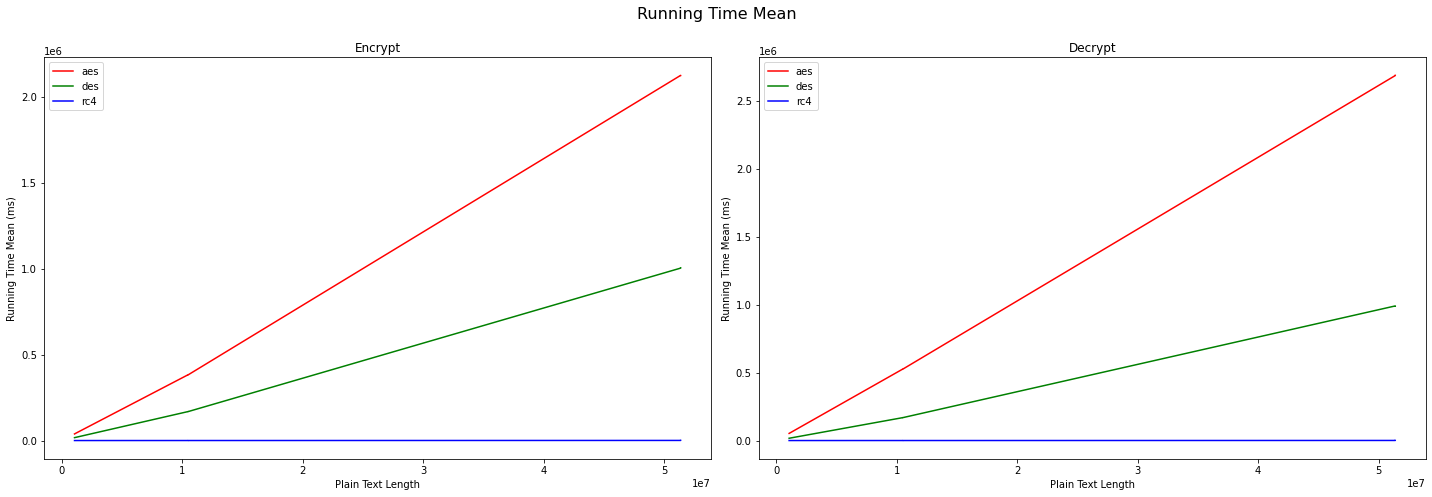

In [26]:
plotEncryptDecryptRunningTimesMean()

# Plot Running Times Population Standard Deviation

In [27]:
def getEncRtPopStdDevTable():
    plainTextLengths = [i.length for i in PT_DATA]
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "aes": [i.encRtPopStdDev for i in RES_DATA["aes"]],
        "des": [i.encRtPopStdDev for i in RES_DATA["des"]],
        "rc4": [i.encRtPopStdDev for i in RES_DATA["rc4"]]
    })

In [28]:
getEncRtPopStdDevTable()

,plain text length,aes,des,rc4
0,1048576,38.754414,28.466114,0.130772
1,1200012,339.931808,30.907164,0.254425
2,10485760,487.429605,322.153329,1.808173
3,10485760,473.994645,360.940227,1.351823
4,51380224,27878.869118,10670.720266,13.803461
5,51380224,25460.978344,10601.281218,23.321380


In [29]:
def getDecRtPopStdDevTable():
    plainTextLengths = [i.length for i in PT_DATA]
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "aes": [i.decRtPopStdDev for i in RES_DATA["aes"]],
        "des": [i.decRtPopStdDev for i in RES_DATA["des"]],
        "rc4": [i.decRtPopStdDev for i in RES_DATA["rc4"]]
    })

In [30]:
getDecRtPopStdDevTable()

,plain text length,aes,des,rc4
0,1048576,50.604524,34.556979,0.913601
1,1200012,95.578927,18.114316,0.222530
2,10485760,1243.221987,130.656591,0.955530
3,10485760,527.010512,319.713960,1.038148
4,51380224,10150.944561,10584.873802,17.398180
5,51380224,10005.559355,8102.780362,23.067092


In [31]:
def plotEncryptDecryptRunningTimesPopStdDev():
    plainTextLengths = [i.length for i in PT_DATA]
    
    # left col: encrypt and right col: decrypt
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Time Population Standard Deviation", fontsize=16)

    ax[0].plot(plainTextLengths, np.array([i.encRtPopStdDev for i in RES_DATA["aes"]]), color='r', label="aes")
    ax[0].plot(plainTextLengths, np.array([i.encRtPopStdDev for i in RES_DATA["des"]]), color='g', label="des")
    ax[0].plot(plainTextLengths, np.array([i.encRtPopStdDev for i in RES_DATA["rc4"]]), color='b', label="rc4")
    
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Running Time Population Standard Deviation')
    ax[0].legend(loc="upper left")
    
    ax[1].plot(plainTextLengths, np.array([i.decRtPopStdDev for i in RES_DATA["aes"]]), color='r', label="aes")
    ax[1].plot(plainTextLengths, np.array([i.decRtPopStdDev for i in RES_DATA["des"]]), color='g', label="des")
    ax[1].plot(plainTextLengths, np.array([i.decRtPopStdDev for i in RES_DATA["rc4"]]), color='b', label="rc4")
    
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Running Time Population Standard Deviation')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

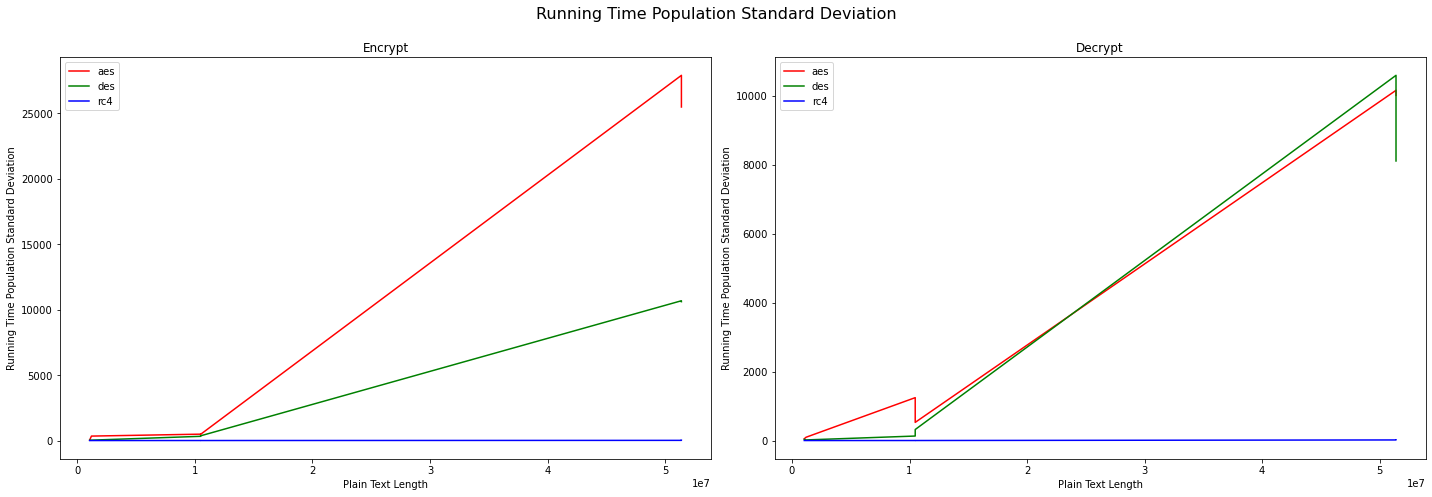

In [32]:
plotEncryptDecryptRunningTimesPopStdDev()

# Compare Plain Text and Cipher Text

In [33]:
def normalize(ptb, ctb):
    if len(ptb) < len(ctb):
        diff = len(ctb) - len(ptb)
        for i in range(0, diff):
            ptb = '0' + ptb

    elif len(ptb) > len(ctb):
        diff = len(ptb) - len(ctb)
        for i in range(0, diff):
            ctb = '0' + ctb
    
    return ptb, ctb

In [34]:
def countTotalDifferentBit(plainTextBin, cipherTextBin):
    if len(plainTextBin) != len(cipherTextBin):
        plainTextBin, cipherTextBin = normalize(plainTextBin, cipherTextBin)
    
    result = 0
    for i in range(0, len(plainTextBin)):
        if plainTextBin[i] != cipherTextBin[i]:
            result += 1
    
    return result

def getTotalDifferentBitTable():
    return pd.DataFrame(data={
        "plain text total bits": [len(i.bins) for i in PT_DATA],
        "aes": [countTotalDifferentBit(PT_DATA[i.plainTextId].bins, i.cipherText.bins) for i in RES_DATA["aes"]],
        "des": [countTotalDifferentBit(PT_DATA[i.plainTextId].bins, i.cipherText.bins) for i in RES_DATA["des"]],
        "rc4": [countTotalDifferentBit(PT_DATA[i.plainTextId].bins, i.cipherText.bins) for i in RES_DATA["rc4"]]
    })

In [35]:
getTotalDifferentBitTable()

,plain text total bits,aes,des,rc4
0,8388608,4194178,4195847,4195277
1,9600096,4800374,4802374,4801864
2,83886080,41945928,41941088,41950125
3,83886080,41944741,41938487,41950125
4,411041792,205538546,205520907,205534173
5,411041792,205522300,205515226,205534173
